# Chapter4 畳み込みニューラルネットワークを学ぶ　～画像分類プログラムを作る～
## 2. CIFAR-10データセットの画像分類【サンプルコード】

In [1]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

     |████████████████████████████████| 6.9MB 6.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 2.1. 前準備（パッケージのインポート）

In [2]:
# 必要なパッケージのインストール
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

## 2.2. 訓練データとテストデータの用意

In [3]:
# CIFAR10データセットの読み込み
train_dataset = torchvision.datasets.CIFAR10(root='./data/',  # データの保存場所
                                             train=True,  # 学習データかどうか
                                             download=True,  # ダウンロードするかどうか
                                             transform=transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(
                                                  [0.5, 0.5, 0.5],  # RGBの平均
                                                  [0.5, 0.5, 0.5],  # RGBの標準偏差
                                                 )
                                             ]))

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False,
                                            download=True,
                                            transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(
                                                    [0.5, 0.5, 0.5],  # RGBの平均
                                                    # RGBの標準偏差
                                                    [0.5, 0.5, 0.5],
                                                )
                                            ]))

# train_datasetの中身を確認
image, label = train_dataset[0]
print("image size: {}".format(image.size()))  # 画像サイズ
print("label: {}".format(label))  # ラベルサイズ

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
image size: torch.Size([3, 32, 32])
label: 6


In [4]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)
test_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)

# ミニバッチデータセットの確認
for images, labels in train_batch:
    print("batch images size: {}".format(images.size()))  # バッチの画像サイズ
    print("image size: {}".format(images[0].size()))  # 1枚の画像サイズ
    print("batch labels size: {}".format(labels.size()))  # バッチのラベルサイズ
    break

batch images size: torch.Size([64, 3, 32, 32])
image size: torch.Size([3, 32, 32])
batch labels size: torch.Size([64])


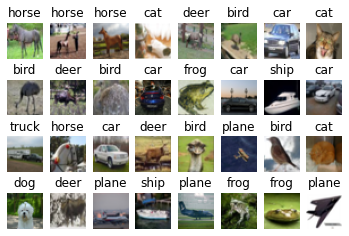

In [5]:
# 画像の確認
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR10のクラス

for images, labels in train_batch:
    for i in range(32):  # 32枚の画像を表示
        image = images[i] / 2 + 0.5  # 標準化を解除
        image = image.numpy()  # Tensorからndarrayへ
        plt.subplot(4, 8, i+1)  # 4x8となるようにプロット
        plt.imshow(np.transpose(image, (1, 2, 0)))  # matplotlibでは(縦, 横, チャネル)の順
        plt.title(classes[labels[i]])  # ラベルをタイトルに
        plt.axis('off')  # 目盛を消去
    plt.show()  # 表示
    break

## 2.3. ニューラルネットワークの定義

In [6]:
# ニューラルネットワークの定義
num_classes = 10  # CIFAR10のクラスの数を指定


class AlexNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=2),  # 畳み込み層
            nn.ReLU(inplace=True),  # 活性化関数
            nn.MaxPool2d(kernel_size=2),  # プーリング層
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),  # ドロップアウト層
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)  # 画像特徴量抽出パート
        x = x.view(x.size(0), 256 * 3 * 3)  # 3次元から1次元に変えて全結合層へ
        x = self.classifier(x)  # 画像分類パート
        return x


# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = AlexNet().to(device)
print(net)
# デバイスの確認
print("Device: {}".format(device))

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

## 2.4. 損失関数と最適化関数の定義

In [7]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 2.5. 学習

In [8]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for images, labels in train_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch)
    epoch_train_accuracy = train_accuracy / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for images, labels in test_batch:
            # GPUにTensorを転送
            images = images.to(device)
            labels = labels.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(images)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch)
    epoch_test_accuracy = test_accuracy / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_accuracy_list.append(epoch_test_accuracy)

---------------------------------------------
Epoch: 1/10
Train_Loss: 1.8207, Train_Accuracy: 0.2937
Test_Loss: 1.5921, Test_Accuracy: 0.3919
---------------------------------------------
Epoch: 2/10
Train_Loss: 1.5454, Train_Accuracy: 0.4248
Test_Loss: 1.3997, Test_Accuracy: 0.4828
---------------------------------------------
Epoch: 3/10
Train_Loss: 1.4147, Train_Accuracy: 0.4818
Test_Loss: 1.3437, Test_Accuracy: 0.5129
---------------------------------------------
Epoch: 4/10
Train_Loss: 1.3015, Train_Accuracy: 0.5275
Test_Loss: 1.2482, Test_Accuracy: 0.5517
---------------------------------------------
Epoch: 5/10
Train_Loss: 1.2217, Train_Accuracy: 0.5612
Test_Loss: 1.2170, Test_Accuracy: 0.5596
---------------------------------------------
Epoch: 6/10
Train_Loss: 1.1584, Train_Accuracy: 0.5864
Test_Loss: 1.1292, Test_Accuracy: 0.5920
---------------------------------------------
Epoch: 7/10
Train_Loss: 1.1000, Train_Accuracy: 0.6089
Test_Loss: 1.0871, Test_Accuracy: 0.6150
------

## 2.6. 結果の可視化

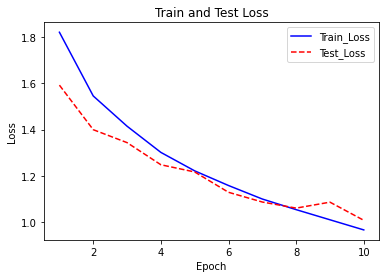

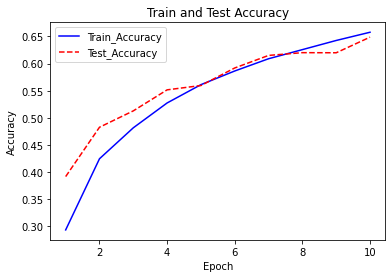

In [9]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

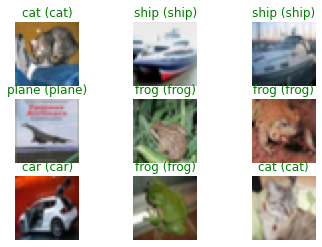

In [10]:
# 分類した画像を確認
# CIFAR10のクラス
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    for images, labels in test_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]

        for i in range(9):  # 9枚の画像を表示
            image = images[i] / 2 + 0.5  # 標準化を解除
            image = image.to('cpu').numpy()  # CPUにTensorを渡してからndarrayへ変換
            plt.subplot(3, 3, i+1)  # 5x8となるようにプロット
            # matplotlibでは(縦, 横, チャネル)の順
            plt.imshow(np.transpose(image, (1, 2, 0)))
            plt.title(classes[labels[i]])  # ラベルをタイトルに
            plt.title("{} ({})".format(classes[y_pred_labels[i].item()],
                                       classes[labels[i].item()]),
                      color=('green' if y_pred_labels[i] == labels[i] else 'red'))  # ラベルをタイトルに
            plt.axis('off')  # 目盛を消去
        plt.show()  # 表示
        break